In [51]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [52]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [53]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
# tf.config.list_physical_devices('GPU')

 ## 2.3 Load Image into TF Data Pipeline

images = tf.data.Dataset.list_files('data\\images\\*.jpg')

images.as_numpy_iterator().next()

In [55]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

 # 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [56]:
import albumentations as alb

In [57]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [58]:
img = cv2.imread(os.path.join('data','train', 'images','2519.jpg'))

In [59]:
with open(os.path.join('data', 'train', 'labels', '2519.json'), 'r') as f:
    label = json.load(f)

In [60]:
label['shapes'][0]['label']

'might cross'

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [61]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [62]:
coords

[671.0588235294117, 371.17647058823525, 719.5882352941176, 524.1176470588235]

In [63]:
img.shape

(720, 1280, 3)

In [64]:
# img = tf.image.resize(img, (720,1280),method='nearest')

In [65]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [66]:
coords

[0.5242647058823529,
 0.5155228758169934,
 0.5621783088235294,
 0.7279411764705882]

In [67]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])

In [68]:
augmented['bboxes'][0][2:]

(0.5621783088235294, 0.7279411764705882)

In [69]:
list(augmented['bboxes'][0])

[0.5242647058823529,
 0.5155228758169934,
 0.5621783088235294,
 0.7279411764705882]

In [70]:
img = tf.image.resize(augmented['image'], (720,1280),method='nearest')
# img = cv2.resize(augmented['image'], (360,640))  

In [71]:
type(augmented['image'])

numpy.ndarray

In [72]:
img

<tf.Tensor: shape=(720, 1280, 3), dtype=uint8, numpy=
array([[[116,  71,  87],
        [ 97,  52,  68],
        [ 82,  39,  54],
        ...,
        [  9,   0,   7],
        [  9,   0,   7],
        [  9,   0,   7]],

       [[114,  69,  85],
        [ 95,  52,  67],
        [ 81,  38,  53],
        ...,
        [  9,   0,   7],
        [  9,   0,   7],
        [  9,   0,   7]],

       [[110,  67,  82],
        [ 92,  49,  64],
        [ 79,  36,  51],
        ...,
        [  9,   0,   7],
        [  9,   0,   7],
        [  9,   0,   7]],

       ...,

       [[ 38,  33,  32],
        [ 38,  33,  32],
        [ 38,  33,  32],
        ...,
        [ 26,   5,  14],
        [ 26,   5,  14],
        [ 26,   5,  14]],

       [[ 36,  31,  30],
        [ 36,  31,  30],
        [ 36,  31,  30],
        ...,
        [ 28,   7,  16],
        [ 28,   7,  16],
        [ 28,   7,  16]],

       [[ 36,  31,  30],
        [ 36,  31,  30],
        [ 36,  31,  30],
        ...,
        [ 28,   7,  

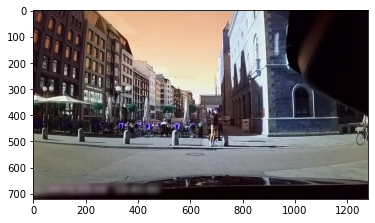

In [73]:
plt.imshow(img)

In [74]:
type(img.numpy())

numpy.ndarray

In [75]:
tuple(np.multiply(augmented['bboxes'][0][:2], [720,1280]).astype(int))

(377, 659)

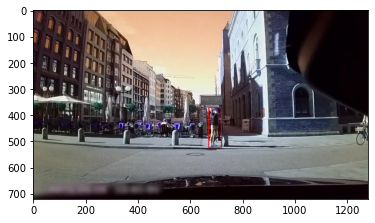

In [76]:
# cv2.rectangle(augmented['image'], 
#               tuple(np.multiply(augmented['bboxes'][0][:2], [1920,1080]).astype(int)),
#               tuple(np.multiply(augmented['bboxes'][0][2:], [1920,1080]).astype(int)), 
#                     (255,0,0), 2)

# plt.imshow(augmented['image'])

image = cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1280,720]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1280,720]).astype(int)), 
                    (255,0,0), 2)
plt.imshow(image)


for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(2):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                # print(len(augmented['bboxes']))
                # print(augmented['class_labels'][0])
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else:
                        # print('in')
                        annotation['bbox'] = list(augmented['bboxes'][0])
                        if augmented['class_labels'][0] == 'crossing':
                            # print('crossing')
                            annotation['class'] = 1
                        elif augmented['class_labels'][0] == 'might cross':
                            annotation['class'] = 2
                        elif augmented['class_labels'][0] == 'not crossing':
                            annotation['class'] = 3

                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [77]:
# train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
# train_images = train_images.map(load_image)
# print(type(train_images))
# # # train_images = train_images.map(lambda x: cv2.resize(x, (120,120), interpolation=cv2.INTER_AREA) )
# train_images = train_images.map(lambda x: print(type(x)))
# # train_images = train_images.map(lambda x: cv2.resize(x, (1280,720)))
# # train_images = train_images.map(lambda x: x/255)

In [78]:
train_images = tf.data.Dataset.list_files('aug_data\\ts\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (720,1280),method='nearest'))
train_images = train_images.map(lambda x: x/255)

In [79]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (720,1280),method='nearest'))
test_images = test_images.map(lambda x: x/255)

In [80]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (720,1280),method='nearest'))
val_images = val_images.map(lambda x: x/255)

In [81]:
train_images.as_numpy_iterator().next()
# val_images.as_numpy_iterator().next()

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.07450981, 0.0627451 , 0.09019608],
        [0.05490196, 0.04313726, 0.07058824],
        [0.02352941, 0.01176471, 0.03921569]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.07450981, 0.0627451 , 0.09019608],
        [0.05490196, 0.04313726, 0.07058824],
        [0.02352941, 0.01176471, 0.03921569]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.07450981, 0.0627451 , 0.09019608],
        [0.05490196, 0.04313726, 0.07058824],
        [0.02352941, 0.01176471, 0.03921569]],

       ...,

       [[0.0627451 , 0.0627451 , 0.10980392],
        [0.0627451 , 0.0627451 , 0.10980392],
        [0.0627451 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [82]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    # print(label['class'])
    # print(label['class'])
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [83]:
# train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
# train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [84]:
train_labels = tf.data.Dataset.list_files('aug_data\\ts\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [85]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [86]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [87]:
train_labels.as_numpy_iterator().next()
# val_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [88]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(100, 100, 228, 228, 258, 258)

### 7.2 Create Final Datasets (Images/Labels)

In [89]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(2)
train = train.prefetch(3)

In [90]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(2)
test = test.prefetch(3)

In [91]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(2)
val = val.prefetch(3)

In [92]:
train.as_numpy_iterator().next()[0].shape
# val.as_numpy_iterator().next()[0].shape

(2, 720, 1280, 3)

### 7.3 View Images and Annotations

In [93]:
data_samples = train.as_numpy_iterator()
# data_samples = val.as_numpy_iterator()

In [111]:
res = data_samples.next()

res[0][0]

# fig, ax = plt.subplots(ncols=3, figsize=(120,120))
# for idx in range(3): 
#     sample_image = res[0][idx]
#     # print(sample_image)
#     sample_coords = res[1][1][idx]
#     # print(np.multiply(sample_coords[:2], [1920,1080]).astype(int))
#     # cv2.rectangle(sample_image, 
#     #               (290.8, 219.6),
#     #               (311 , 391), 
#     #                     (255,0,0), 2)
#     cv2.rectangle(sample_image, 
#                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
#                         (255,0,0), 1)

#     ax[idx].imshow(sample_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00625 0.839   0.03403 0.944  ]
[  7 603]
[ 43 679]


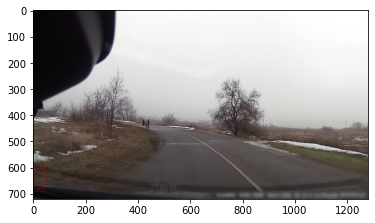

In [113]:
idx=0
sample_image = res[0][0]
# print(sample_image)
sample_coords = res[1][1][0]
print(sample_coords)
print(np.multiply(sample_coords[:2], [1280,720]).astype(int))
print(np.multiply(sample_coords[2:], [1280,720]).astype(int))
# # cv2.rectangle(sample_image, 
# #               (290.8, 219.6),
# #               (311 , 391), 
# #                     (255,0,0), 2)
final_image = cv2.rectangle(sample_image, 
              tuple(np.multiply(sample_coords[:2], [1280,720]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [1280,720]).astype(int)), 
              (255,0,0), 1)

plt.imshow(final_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [114]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [115]:
vgg = VGG16(include_top=False)

In [116]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [117]:
def build_model(): 
    input_layer = Input(shape=(720, 1280,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [118]:
facetracker = build_model()

In [119]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [120]:
X, y = train.as_numpy_iterator().next()

In [121]:
X.shape

(2, 720, 1280, 3)

In [122]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 20s 20s/step


In [123]:
classes, coords

(array([[0.48521796],
        [0.5034743 ]], dtype=float32),
 array([[0.43072203, 0.5591433 , 0.6616523 , 0.3897813 ],
        [0.43499756, 0.5372342 , 0.56756604, 0.31176826]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [124]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [125]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [126]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [127]:
classloss = tf.keras.losses.CategoricalCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [128]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8581501>

In [129]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7881396e-07>

In [130]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8581501>

In [131]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [132]:
model = FaceTracker(facetracker)

In [133]:
model.compile(opt, classloss, regressloss,metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [134]:
logdir='logs'

In [135]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_callback = tf.keras.callbacks.EarlyStopping(monitor='total_loss', patience=5)

In [136]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=tensorboard_callback)

Epoch 1/5
50/50 [==============================] - 179s 3s/step - total_loss: 0.4764 - class_loss: 1.1337e-07 - regress_loss: 0.4764 - val_total_loss: 0.6032 - val_class_loss: 1.1921e-07 - val_regress_loss: 0.6032
Epoch 2/5
50/50 [==============================] - 161s 3s/step - total_loss: 0.4498 - class_loss: 1.1570e-07 - regress_loss: 0.4498 - val_total_loss: 0.1476 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.1476
Epoch 3/5
50/50 [==============================] - 160s 3s/step - total_loss: 0.3919 - class_loss: 1.1453e-07 - regress_loss: 0.3919 - val_total_loss: 0.4451 - val_class_loss: 5.9605e-08 - val_regress_loss: 0.4451
Epoch 4/5
50/50 [==============================] - 156s 3s/step - total_loss: 0.4088 - class_loss: 1.1337e-07 - regress_loss: 0.4088 - val_total_loss: 0.0548 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0548
Epoch 5/5
50/50 [==============================] - 153s 3s/step - total_loss: 0.3399 - class_loss: 1.1337e-07 - regress_loss: 0.3399 - val_total

In [137]:
hist.history

{'total_loss': [0.15385591983795166,
  1.7539325952529907,
  0.6204386353492737,
  0.15149277448654175,
  0.5525802373886108],
 'class_loss': [5.960465188081798e-08,
  1.788139627478813e-07,
  1.1920930376163597e-07,
  5.960465188081798e-08,
  5.960465188081798e-08],
 'regress_loss': [0.15385589003562927,
  1.7539324760437012,
  0.6204385757446289,
  0.15149274468421936,
  0.5525801777839661],
 'val_total_loss': [0.6032469272613525,
  0.14759127795696259,
  0.44508951902389526,
  0.054828058928251266,
  0.10127221047878265],
 'val_class_loss': [1.1920930376163597e-07,
  0.0,
  5.960465188081798e-08,
  0.0,
  1.788139627478813e-07],
 'val_regress_loss': [0.6032468676567078,
  0.14759127795696259,
  0.4450894892215729,
  0.054828058928251266,
  0.10127212107181549]}

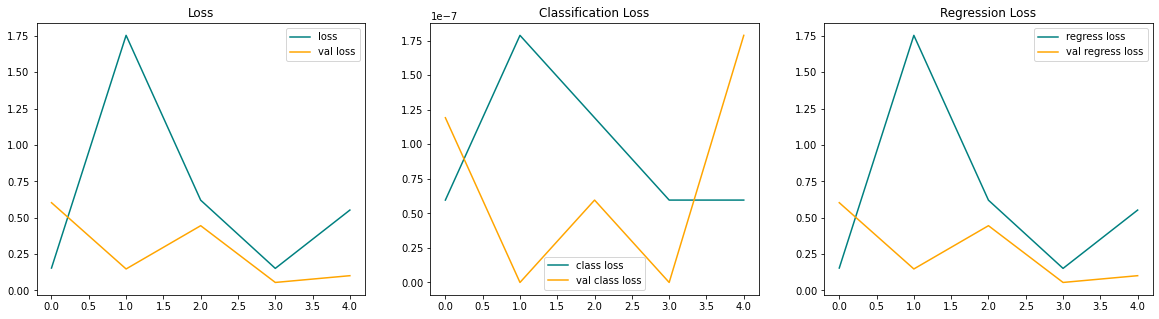

In [138]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [139]:
test_data = test.as_numpy_iterator()

In [178]:
test_sample = test_data.next()

In [179]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 327ms/step


In [180]:
yhat[0]

array([[0.41709012],
       [0.43601403]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(401, 285)
(447, 297)
(332, 264)
(398, 279)
(401, 285)
(447, 297)
(332, 264)
(398, 279)


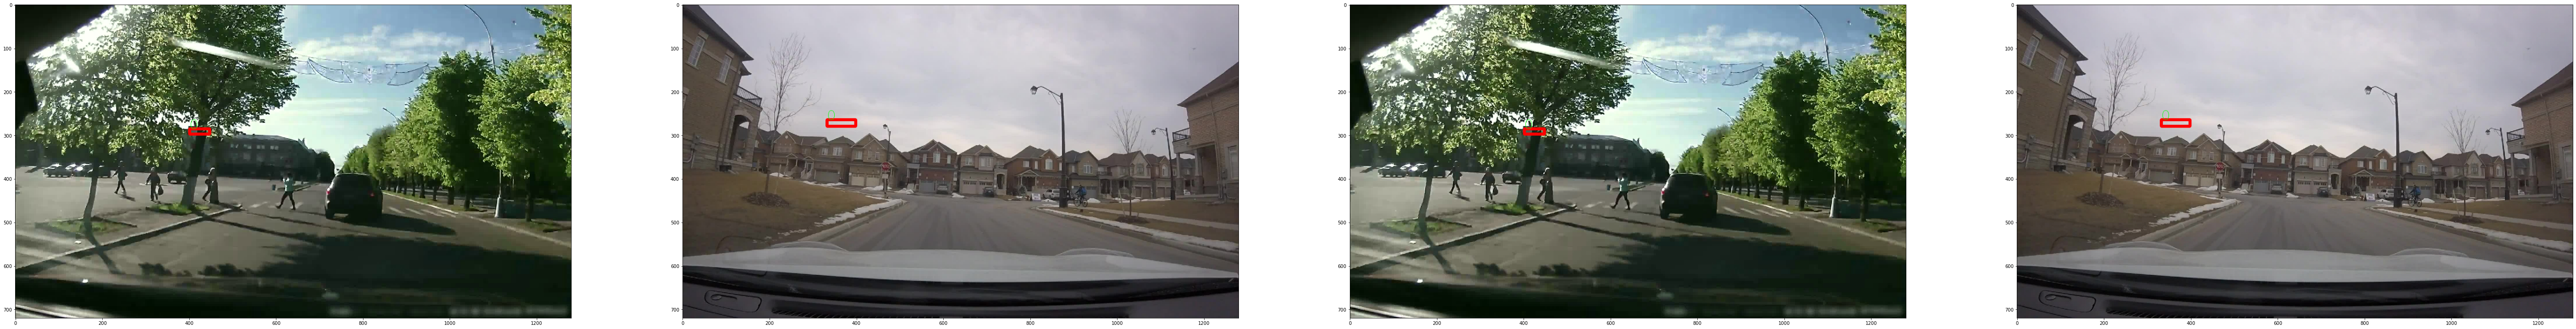

In [181]:
fig, ax = plt.subplots(ncols=4, figsize=(100,100))
clf=''
for idx in range(4): 
    sample_image = test_sample[0][idx-2]
    sample_coords = yhat[1][idx-2]
    
    if yhat[1][0][idx] < 0.9:
        clf = int(yhat[0][idx-2])
        print(tuple(np.multiply(sample_coords[:2], [1280,720]).astype(int)))
        print(tuple(np.multiply(sample_coords[2:], [1280,720]).astype(int)))
        final_image = cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [1280,720]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [1280,720]).astype(int)), 
                            (255,0,0), 5)
        fimage = cv2.putText(final_image, str(clf), tuple(np.multiply(sample_coords[:2], [1280,720]).astype(int)),cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0), 1, cv2.LINE_AA)
    
    ax[idx].imshow(final_image)

In [177]:
facetracker.save('pedestrian.h5')